In [6]:
# import das bibliotecas
import numpy as np
import imageio
import matplotlib.pyplot as plt
from skimage import morphology

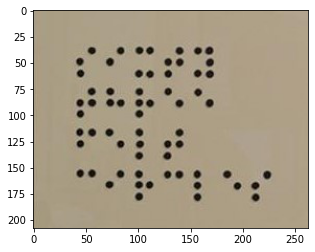

In [ ]:
# leitura da imagem de input
img = imageio.imread('img_input.jpg')
plt.imshow(img);

# Pré Processamento

Para o trabalho da segmentação, queremos destacar apenas as características que desejamos (os círculos em braile). Portanto convertemos para escala de cinza e binarizamos-a a fim de eliminar informações indesejadas da imagem.

In [7]:
# converte uma imagem RGB para escala de cinza (matriz 2d)
def convert_gray_scale(img):
    if len(img) == 2:
        return img

    gray_img = img.sum(axis=2) / 3
    return gray_img.astype(np.uint8)

# retorna o complemento de uma imagem binária passada
def complement(img):
    compl_img = (img.astype(float)-1).astype(np.uint8)
    compl_img[compl_img == 255] = 1
    return compl_img

# aplica uma linearização da imagem
def linearization(img, t0):
    # otimiza t0
    while True:
        # 2 grupos da imagem e suas intensidades médias de acordo com t
        g1 = np.where(img > t0)
        g2 = np.where(img <= t0)
        
        u1 = np.mean(img[g1])
        u2 = np.mean(img[g2])
        
        t1 = (u1 + u2) / 2 # calcula o novo t
        
        # fim da otimização
        if abs(t0 - t1) < 0.5:
            t1 = int(t1)
            break
        
        t0 = t1
        
    # com o t otimizado, aplica a linearização
    ind = np.where(img > t1)
    binary = np.zeros(img.shape).astype(np.uint8)
    binary[ind] = 1
        
    return binary

(208, 263)



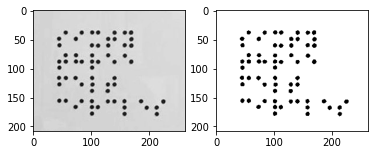

In [ ]:
gray_img = convert_gray_scale(img)
bin_img = linearization(gray_img, 127)

print(gray_img.shape, end='\n\n')

f, ax = plt.subplots(1,2)
ax[0].imshow(gray_img, cmap='gray')
ax[1].imshow(bin_img, cmap='gray');

Além disso, para utilizar da segmentação, será necessário que os pontos estejam em 1 (branco) e o fundo em 0 (preto).

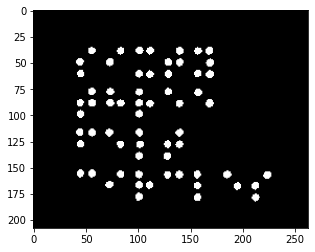

In [ ]:
# retorna o complemento de uma imagem binária passada
def complement(img):
    compl_img = (img.astype(float)-1).astype(np.uint8)
    compl_img[compl_img == 255] = 1
    return compl_img

# inverte a imagem se necessário para a maioria dos pixels serem 0
img_size = bin_img.shape[0] * bin_img.shape[1]
if np.count_nonzero(bin_img) > img_size // 2:
    bin_img = complement(bin_img)

plt.imshow(bin_img, cmap='gray');

Após o pré-processamento das cores, utilizamos da morfologia para eliminar imperfeições dos círculos destacados.

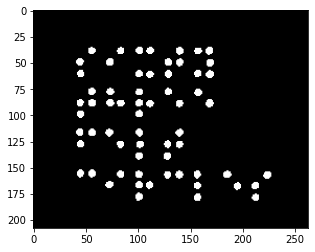

In [ ]:
def apply_morphology(img, point_size):
    # reduz as irregularidades nos pixels dos pontos identificados
    proc_img = morphology.closing(img, morphology.disk(point_size*0.7)) # reduz os buracos internos
    proc_img = morphology.opening(proc_img, morphology.disk(point_size*0.7)) # reduz os vales nas bordas

    # ajusta os formatos dos pontos para ficarem mais circulares
    if point_size >= 2.5:
        proc_img = morphology.skeletonize(proc_img).astype(np.uint8)
        proc_img = morphology.dilation(proc_img, morphology.disk(point_size))

    return proc_img

proc_img = apply_morphology(bin_img, 2) # o tamanho dos pontos (círculos) é um parâmetro definido pelo usuário
plt.imshow(proc_img, cmap='gray');

Neste exemplo, a morfologia aplicada não fez muita diferença já que os pontos da imagem já estão bem definidos. Contudo, utilizando como exemplo as imagem binarizadas as seguir:

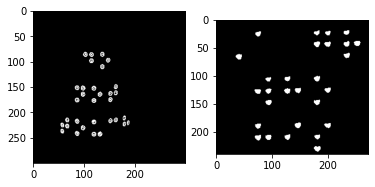

In [ ]:
img_test = imageio.imread('img_test_morph.jpg')
img_test1 = imageio.imread('img_test_morph1.jpg')

img_test = linearization(img_test, 127)
img_test1 = linearization(img_test1, 127)

f, ax = plt.subplots(1,2)
ax[0].imshow(img_test, cmap='gray')
ax[1].imshow(img_test1, cmap='gray');

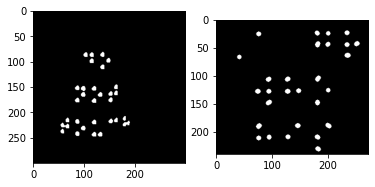

In [ ]:
proc_img_test = apply_morphology(img_test, 2.4)
proc_img_test1 = apply_morphology(img_test1, 4)

f, ax = plt.subplots(1,2)
ax[0].imshow(proc_img_test, cmap='gray')
ax[1].imshow(proc_img_test1, cmap='gray');

Percebe-se então que a morfologia aplicada conseguiu preencher os espaços irregulares internos ao círculo (na primeira imagem) utilizando do oppening e closing com filtros circulares. Também conseguiu reajustar o formato dos círculos (na segunda imagem) com o auxílio do **skimage.morphology.skeletonize** (transformada da distância) e uma dilatação com filtro circular em seguida.

# Segmentação

Voltando então à imagem de exemplo inicial, após o seu pré processamento, é possível aplicar o algoritmo que segmenta a imagem total separando-a em subimagens de cada letra considerando a distância entre os pontos (nos eixos vertical e horizontal).

In [ ]:
# retorna os limites de início e fim das linhas
def def_vertical_points(img, tolerance, j_lines):
    # variáveis base
    limits = []
    y = 0

    # intera sobre toda imagem verticalmente
    while y < img.shape[0]:
        lim = []
        # encontra a borda de cima da linha
        while y < img.shape[0] and np.count_nonzero(img[y,:]) <= tolerance * img.shape[1]:
            y += 1
        
        if y >= img.shape[0]: break
        lim.append(y-1)

        # encontra a borda de baixo da linha
        count = 0
        while count <= j_lines and y < img.shape[0]:
            if np.count_nonzero(img[y,:]) <= tolerance * img.shape[1]: count += 1
            else: count = 0
            y += 1

        lim.append(y-1)
        limits.append(lim)

    return limits

# retorna os limites de início e fim das letras na linha
def def_horizontal_points(img_line, tolerance, j_columns):
    # variáveis base
    limits = []
    x = 0

    # intera sobre toda linha horizontalmente
    while x < img_line.shape[1]:
        lim = []
        # encontra a borda da esquerda da letra
        while x < img_line.shape[1] and np.count_nonzero(img_line[:,x]) <= tolerance * img_line.shape[0]:
            x += 1
        
        if x >= img_line.shape[1]: break
        lim.append(x-1)

        # encontra a borda da direita da letra
        count = 0
        while count <= j_columns and x < img_line.shape[1]:
            if np.count_nonzero(img_line[:,x]) <= tolerance * img_line.shape[0]: count += 1
            else: count = 0
            x += 1

        lim.append(x-1)
        limits.append(lim)

    return limits

# separa, da imagem passada, todas as letras em braile presentes
def get_img_letters(img, tolerance, j_lines, j_columns, word_space):
    
    # extração das imagens das linhas
    lim_y = def_vertical_points(img, tolerance, j_lines)
    lines_img = []

    for i in range(len(lim_y)):
        lines_img.append(img[lim_y[i][0] : lim_y[i][1], :])

    # extração das imagens das letras e do tamanho das palavras
    letters_imgs = []
    words_len = []
    letter_count = 0

    for line in lines_img:
        # para cada imagem de linha, divide-a em letras
        lim_x = def_horizontal_points(line, tolerance, j_columns)

        for i in range(len(lim_x)):
            letters_imgs.append(line[:, lim_x[i][0] : lim_x[i][1]])
            
            # se possui espaço suficiente entre as letras para considerar uma nova palavra
            if i > 0 and lim_x[i][0] - lim_x[i-1][1] > j_columns * word_space:
                words_len.append(letter_count)
                letter_count = 1
            else:
                letter_count += 1

        # cada linha nova considera uma nova palavra
        words_len.append(letter_count)
        letter_count = 0

    return letters_imgs, words_len

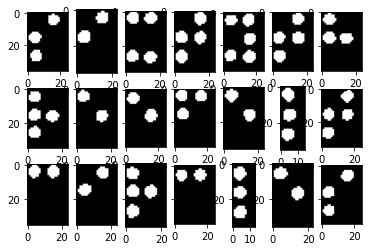

In [ ]:
letters, words_len = get_img_letters(proc_img, 0.01, 5, 5, 2) # parâmetros definidos pelo usuário

f, ax = plt.subplots(3, 7)
for i in range(3):
    for j in range(7):
      ax[i][j].imshow(letters[j+7*i], cmap='gray')

Lembrando também que, apesar dos parâmetros de split da imagem serem definidos pelo usuário, os parâmetros **j_lines** e **j_columns** da função são otimizados, em um método da classe de segmentação **Segment_letters** do código principal, visando aproximar a 1 os scores relacionados ao quociente entre os diferentes tamanhos das sub-imagens:
```
all_score = np.min(img_sizes) / np.max(img_sizes)
min_score = np.min(img_sizes) / np.median(img_sizes)
max_score = np.median(img_sizes) / np.max(img_sizes)
```
Dessa forma, é possível apenas passar valores estimados para a divisão no algoritmo que ele mesmo melhora-os durante as **n** interações (definidas pelo usuário). Contudo, é importante lembrar que, como esse algoritmo de otimização apenas tenta reduzir a diferença entre os tamanhos das sub-imagens, nem sempre ele caminha para a otimização correta! (por isso que é importante existir um controle sobre o valor de **n**).



### Tradução

A Matriz de co-ocorrência foi um dos indicadores morfológicos utilizados para associar cada letra em Braile da imagem a uma letra do Alfabeto. Ela é útil para identificação de tipos de imagem via cálculo dos descritores Haralick de textura. Abaixo há a implementação da mesma, não utilizando os métodos da biblioteca, e sim os produzidos em trabalhos práticos da disciplina.

In [11]:
#Dilation function, structure 3x3
def Dilation(img):
    #Acquire size of the image
    p,q = img.shape    
    #Define new image to store the pixels of dilated image
    imgDilate = np.zeros((p,q))
    #Define the structuring element
    #SED= np.array([[1,1,1], [1,1,1],[1,1,1]])
    for i in range(1, p-1):
        for j in range(1,q-1):
            temp= img[i-1:i+2, j-1:j+2]
            #product= temp*SED
            imgDilate[i,j]= np.max(temp)
    return imgDilate 

#Erosion function, structure 3x3
def Erosion(img):
    p,q= img.shape    
    imgDilate = np.zeros((p,q))
    #SED = np.array([[1,1,1], [1,1,1],[1,1,1]])
    for i in range(1, p-1):
        for j in range(1,q-1):
            temp= img[i-1:i+2, j-1:j+2]
            #product= temp*SED
            imgDilate[i,j]= np.min(temp)

    return imgDilate

#Chossing method
def Morphlogy(img, m_type):
    if(m_type == 1): #Opening = (Erosion + Dilation)
        #Erosion
        img_erosion = Erosion(img)
        #Dilation
        img_dilation = Dilation(img_erosion)
        return img_dilation

    else: #Closing (Dilation + Erosion)
        #Dilation
        img_dilation = Dilation(img)
        #Erosion
        img_erosion = Erosion(img_dilation)
        return img_erosion

#Masks to matrix
def Masks(img_morph, img_lum):
    mask1 = np.zeros(img_morph.shape)
    mask2 = np.zeros(img_morph.shape)
    #Getting mask1 and mask2
    for i in range(img_morph.shape[0]):
        for j in range(img_morph.shape[1]):
            if(img_morph[i][j]==0):
                mask1[i][j] = img_lum[i][j]
            else:
                mask2[i][j] = img_lum[i][j]
    r = np.zeros((2, mask1.shape[0], mask1.shape[1]))
    r[0] = mask1
    r[1] = mask2
    return r

#Co-occurrence matrix
def CoMatrix(img, q_values):
    graylevels = int(np.max(img)+1)
    matrix = np.zeros((graylevels, graylevels))
    for i in range(1, np.shape(img)[0]-1):
        for j in range (1, np.shape(img)[1]-1):
            x = int(img[i][j])
            y = int(img[int(i+q_values[0])][int(j+q_values[1])])
            matrix[x][y]+=1

    #Normalized to sum = 1 (probabilities matrix)
    return matrix/(np.sum(matrix))

#Computing descriptors for masks
def Haralick(matrix):
    i, j = np.indices(matrix.shape)

    h1 = np.sum((i*j)*matrix) #Auto-correlation
    h2 = np.sum(np.power(i-j, 2)*matrix) #Contrast
    h3 = np.sum(np.abs(i,j) * matrix) #Dissimilarity
    h4 = np.sum(matrix**2) #Energy
    h5 = -np.sum(np.log(matrix[matrix > 0])*matrix[matrix > 0]) #Entropy
    h6 = np.sum(matrix/(1+ (i-j)**2)) #Homogeneity
    h7 = np.sum(matrix/(1+ np.abs(i-j))) #Inverse Difference
    h8 = np.max(matrix) #Maximum Probability
    all_descriptors = [h1,h2,h3,h4,h5,h6,h7,h8]
    return all_descriptors

#Gray Level Co-Ocurrence Matrix
def GLCM(img, q_value,  param_f, param_t):
    img_lum = img
    img_b = linearization(img_lum, param_t)
    img_morph = Morphlogy(img_b, param_f)
    r = Masks(img_morph, img_lum)
    mask1_prob = CoMatrix(r[0], q_value)
    mask2_prob = CoMatrix(r[1], q_value)
    mask1_descriptor = Haralick(mask1_prob)
    mask2_descriptor = Haralick(mask2_prob)
    return np.concatenate((mask1_descriptor, mask2_descriptor), axis = None)

Alguns métodos auxiliares foram utilizados para confecção dos métodos principais, como alterar as medidas das imagens para operações:

In [10]:
# ajusta o padding das imagens para possuirem o mesmo tamanho
def equal_size(img1, img2):

    for axis in (0, 1):
        diff_shape = img1.shape[axis] - img2.shape[axis]

        # cálculo do padding
        if diff_shape % 2 == 0:
            pad_axis = (int(np.abs(diff_shape) / 2), int(np.abs(diff_shape) / 2))
        else:
            pad_axis = (np.abs(diff_shape) // 2, (np.abs(diff_shape) // 2)+1)

        padding = [[0,0],[0,0]]
        padding[axis] = pad_axis

        if diff_shape < 0:
            img1 = np.pad(img1, padding, 'constant')
        elif diff_shape > 0:
            img2 = np.pad(img2, padding, 'constant')

    return img1, img2

In [1]:
def normalize_minmax(f, factor):
    f_min = np.min(f)
    f_max = np.max(f)
    f = (f - f_min)/(f_max-f_min)
    return (f*factor)

## Raiz quadrada do erro-médio
A Root mean squared error foi utilizada na maioria dos Assignments da disciplina, portanto foi uma solução em potencial na maneira de comparar as letras segmentadas com seu devido significado.

In [2]:
#Raiz quadrada do erro médio
def RMSE(img, output):
  MSE = np.square(np.subtract(img,output)).mean() 
  return np.sqrt(MSE)

Definindo a estrutura do Alfabeto

In [3]:
def Alfabeto():
  imagens = []
  for k in range(ord('a'), ord('z')+1):
    img = imageio.imread(chr(k)+".png")
    img_2d = convert_gray_scale(img)
    img_b = linearization(img_2d, 127)
    imagens.append((img_b, k))
  return imagens

Traduzindo cada letra da imagem via imagens de um Alfabeto "gabarito"


In [4]:
def Traducao(filename_img, q_value, param_f, param_t, cont):
  img = Alfabeto()
  query = imageio.imread(filename_img)


  #RMSE
  values = []
  for i in range (len(img)):
    img_query, img_letter = equal_size(query, img[i][0])
    img_query = np.asarray(img_query)
    a = linearization(img_query, param_t)
    b = np.asarray(img_letter)
    values.append((RMSE(a,b), chr(img[i][1])))
  values.sort(key = lambda x: x[0], reverse=False)

  lista_rmse = []
  for i in range (cont):
    lista_rmse.append((values[i][1]))

  #Number of letters
  b = 26

  #GLCM
  alphabet = np.zeros((b,16))

  #Computing the GLCM for all letters of Alphabet
  for i in range(b):
      alphabet[i] = GLCM(img[i][0], q_value, param_f, param_t)

  #Euclidean distance of arrays
  euclidean_distance = np.zeros(b)

  #Normalize to (0,1)
  index = GLCM(np.asarray(query), q_value, param_f, param_t)
  for i in range(b):
      euclidean_distance[i] = np.linalg.norm(alphabet[i]-index)

  #Euclidean similarity
  similarities = 1-normalize_minmax(euclidean_distance,1)

  lista = []
  for i in range(b):
      lista.append((similarities[i], img[i][1]))
  #Sorting letters by similarity
  lista.sort(key = lambda x: x[0], reverse=True)


  lista_haralick = []
  for i in range (cont):
    lista_haralick.append(chr(lista[i][1]))

  #Verifying letters in both lists according to parameter "quantity"
  c = [elemento for elemento in lista_rmse if elemento in lista_haralick]

  #Grouping by similarity and error
  if(len(c)<1):
    print(lista_rmse[0])
  else:
    print(c[0])

O resultado esperado seria "do not touch"

In [15]:
#Foram alterados alguns parâmetros a fins de amostrar variadas
Traducao("00.jpg", [1,-1], 1, 127, 4)
Traducao("01.jpg", [0,-1], 0, 127, 12)
Traducao("10.jpg", [-1,-1], 1, 127, 10)
Traducao("11.jpg", [1,-1], 0, 127, 12)
Traducao("12.jpg", [-1,-1], 1, 127, 12)
Traducao("20.jpg", [1,-1], 0, 127, 12)
Traducao("21.jpg", [1,0], 1, 127, 12)
Traducao("22.jpg", [1,-1], 0, 127, 10)
Traducao("23.jpg", [0,-1], 1, 127, 15)
Traducao("24.jpg", [1,-1], 1, 127, 11)

d
o
n
o
t
t
o
a
h
a


Mesmo utilizando as técnicas vistas em aula, a escolha deste método não foi tão proveitosa, demostrando uma acurácia relevante, porém imperfeita. Após planejarmos um pouco talvez segmentar cada letra fosse uma alternativa mais precisa.